In [1]:
%matplotlib inline

import json
import math

import numpy
import matplotlib.pyplot as plot
import pandas

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.grid_search import GridSearchCV

In [2]:
with open('pos_russian_reviews.json') as data_file:    
    data_pos = json.load(data_file)
with open('neg_russian_reviews.json') as data_file:    
    data_neg = json.load(data_file)
# with open('pos_reviews.json') as data_file:    
#     data_pos = json.load(data_file)
# with open('neg_reviews.json') as data_file:    
#     data_neg = json.load(data_file)

pos_texts = data_pos.keys()[:1000]
neg_texts = data_neg.keys()[:1000]
all_texts = pos_texts + neg_texts

N_POS_TEXTS = len(pos_texts)
N_NEG_TEXTS = len(neg_texts)
target = [1]*N_POS_TEXTS + [0]*N_NEG_TEXTS

In [3]:
def mean_length(texts):
    return sum(len(text) for text in texts)/len(texts)

In [4]:
print "Позитивных текстов: " + str(N_POS_TEXTS)
print "Негативных текстов: " + str(N_NEG_TEXTS)

print "Средняя длина позитивных текстов: " + str(mean_length(pos_texts))
print "Средняя длина негативных текстов: " + str(mean_length(neg_texts))

Позитивных текстов: 1000
Негативных текстов: 1000
Средняя длина позитивных текстов: 310
Средняя длина негативных текстов: 347


In [5]:
def f1_measure(P,R):
    return [2*x*y/(x+y) for x,y in zip(P, R)]

In [6]:
def cross_valid(matrix_counts, target, test_size=0.3, random_state=0):
    X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
    return (X_train, X_test, Y_train, Y_test)

In [7]:
def rp_curve(Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, precision, label=label);
    plot.xlabel('Recall'); plot.ylabel('Precision'); 
    plot.legend(loc=0); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1])
    
def f1_curve(Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, f1_measure(precision, recall), label=label)
    plot.xlabel('Recall'); plot.ylabel('F1-measure'); 
    plot.legend(loc=0); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1])

def roc_curve(Y_test, predicted, label='?'):
    fpr, tpr, th = metrics.roc_curve(Y_test, predicted[:,1])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('False Positive'); plot.ylabel('True Positive'); 
    plot.legend(loc=0); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print '(', label, ') AUC = ', metrics.auc(fpr, tpr)
    print '(', label, ') F1 = ', get_f1score(Y_test, predicted)
    print '(', label, ') Accuracy = ', get_accuracy(Y_test, predicted)
    
from sklearn.metrics import accuracy_score
def get_accuracy(Y_test, predicted):
    new_predicted = [1 if list[0] < list[1] else 0 for list in predicted]
    return accuracy_score(Y_test, new_predicted)

from sklearn.metrics import f1_score
def get_f1score(Y_test, predicted):
    new_predicted = [1 if list[0] < list[1] else 0 for list in predicted]
    return f1_score(Y_test, new_predicted)

def get_auc(Y_test, predicted):
    fpr, tpr, _ = metrics.roc_curve(Y_test, predicted[:,1])
    return metrics.auc(fpr, tpr)

In [8]:
def report_cross_validation(grid_searcher, X_test, Y_test):
    print 'train score is {:.5f}'.format(grid_searcher.best_score_)
    print 'test score is {:.5f}'.format(grid_searcher.score(X_test, Y_test))
    print 'best parameter set:'
    for k in sorted(grid_searcher.best_params_):
        print ' * {}={}'.format(k, grid_searcher.best_params_[k])

In [9]:
def logistic_reg(X_train, X_test, Y_train, **kwargs):
    model_logistic = LogisticRegression(**kwargs)
    model_logistic.fit(X_train, Y_train)
    predicted = model_logistic.predict_proba(X_test)
    return predicted, model_logistic

In [10]:
count_vect = CountVectorizer()
temp_matrix = count_vect.fit_transform(all_texts) # temp_matrix for calc tf-idf
matrix_counts = temp_matrix.toarray()

N_FEATURES = matrix_counts.shape[1]
words_as_features = {count_vect.vocabulary_.get(x):x for x in count_vect.vocabulary_}

print "Number of features: " + str(N_FEATURES)

Number of features: 24918


# L2 vs L1

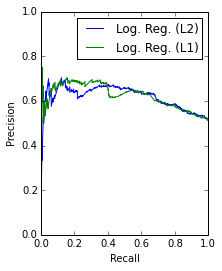

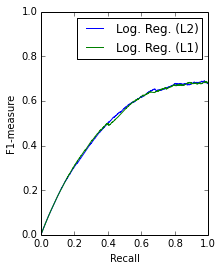

( Log. Reg. (L2) ) AUC =  0.644380448319
( Log. Reg. (L2) ) F1 =  0.616915422886
( Log. Reg. (L2) ) Accuracy =  0.615
( Log. Reg. (L1) ) AUC =  0.641228206725
( Log. Reg. (L1) ) F1 =  0.603119584055
( Log. Reg. (L1) ) Accuracy =  0.618333333333


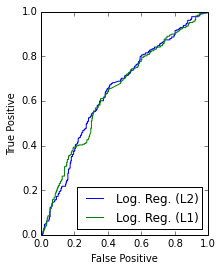

In [11]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, log_counts_model = logistic_reg(X_train, X_test, Y_train)
logreg_counts_l1_predicted, _ = logistic_reg(X_train, X_test, Y_train, penalty='l1')

plot.figure(figsize=(3,4))
rp_curve(Y_test, logreg_counts_l2_predicted, label='Log. Reg. (L2)')
rp_curve(Y_test, logreg_counts_l1_predicted, label='Log. Reg. (L1)')
plot.show()
plot.figure(figsize=(3,4))
f1_curve(Y_test, logreg_counts_l2_predicted, label='Log. Reg. (L2)')
f1_curve(Y_test, logreg_counts_l1_predicted, label='Log. Reg. (L1)')
plot.show()
plot.figure(figsize=(3,4))
roc_curve(Y_test, logreg_counts_l2_predicted, label='Log. Reg. (L2)')
roc_curve(Y_test, logreg_counts_l1_predicted, label='Log. Reg. (L1)')

# Подбор коэффициента C для L1- и L2-рег. лог рег

In [60]:
c = [2**(x/10.0) for x in xrange(-50, 101, 10)]

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid={
        'C': c,
        'penalty': ['l1', 'l2']
    }, 
    scoring='roc_auc', cv=10, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.68252
test score is 0.63000
best parameter set:
 * C=0.25
 * penalty=l2


another method max auc = 0.682516136154 with c =  0.25 2^ -2.0


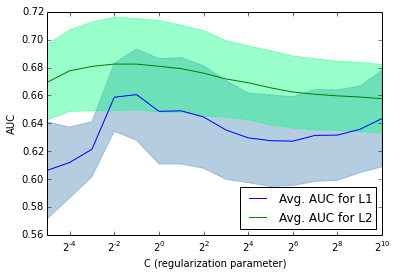

In [61]:
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
print "another method max auc =", l2_mean.max(), "with c = ", c[numpy.where(l2_mean==l2_mean.max())[0][0]], "2^", math.log(c[numpy.where(l2_mean==l2_mean.max())[0][0]], 2)
plot.fill_between(c, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c, l1_mean, label='Avg. AUC for L1')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('AUC'); 
plot.fill_between(c, l2_mean - l2_std, l2_mean + l2_std, color = 'springgreen', alpha = .4)
plot.plot(c, l2_mean, label='Avg. AUC for L2')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('AUC'); 

In [56]:
c = [2**(x/10.0) for x in xrange(-50, 101, 10)]

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid={
        'C': c,
        'penalty': ['l1', 'l2']
    }, 
    scoring='accuracy', cv=10, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.64500
test score is 0.62500
best parameter set:
 * C=0.5
 * penalty=l2


another method max auc = 0.645 with c =  0.5 2^ -1.0


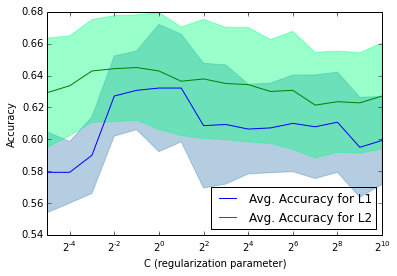

In [57]:
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
print "another method max auc =", l2_mean.max(), "with c = ", c[numpy.where(l2_mean==l2_mean.max())[0][0]], "2^", math.log(c[numpy.where(l2_mean==l2_mean.max())[0][0]], 2)
plot.fill_between(c, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c, l1_mean, label='Avg. Accuracy for L1')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('Accuracy'); 
plot.fill_between(c, l2_mean - l2_std, l2_mean + l2_std, color = 'springgreen', alpha = .4)
plot.plot(c, l2_mean, label='Avg. Accuracy for L2')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('Accuracy'); 

In [58]:
c = [2**(x/10.0) for x in xrange(-50, 101, 10)]

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid={
        'C': c,
        'penalty': ['l1', 'l2']
    }, 
    scoring='f1', cv=10, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.62857
test score is 0.62500
best parameter set:
 * C=0.5
 * penalty=l2


another method max auc = 0.628569034511 with c =  0.5 2^ -1.0


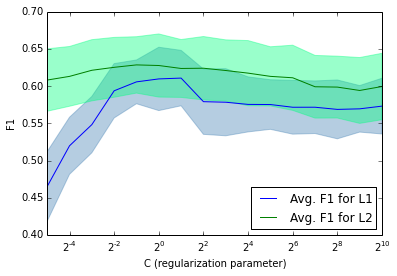

In [59]:
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
print "another method max auc =", l2_mean.max(), "with c = ", c[numpy.where(l2_mean==l2_mean.max())[0][0]], "2^", math.log(c[numpy.where(l2_mean==l2_mean.max())[0][0]], 2)
plot.fill_between(c, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c, l1_mean, label='Avg. F1 for L1')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('F1'); 
plot.fill_between(c, l2_mean - l2_std, l2_mean + l2_std, color = 'springgreen', alpha = .4)
plot.plot(c, l2_mean, label='Avg. F1 for L2')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('F1'); 

# Выбор наиболее частотных признаков

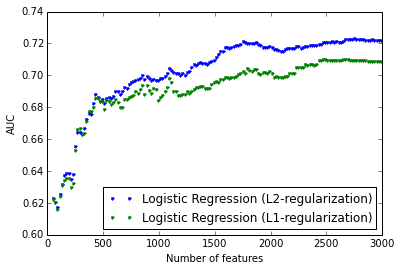

In [12]:
auc_map = {}
for i in xrange(50,3000,20):
    count_vect_top_temp = CountVectorizer(max_features=i)
    matrix_counts_top_temp = count_vect_top_temp.fit_transform(all_texts).toarray()
    X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_top_temp, target)
    logreg_count_top_temp_predicted, _ = logistic_reg(X_train, X_test, Y_train, penalty='l1', C=1)
    auc_map[i] = get_auc(Y_test, logreg_count_top_temp_predicted)
    
auc_map2 = {}
for i in xrange(50,3000,20):
    count_vect_top_temp = CountVectorizer(max_features=i)
    matrix_counts_top_temp = count_vect_top_temp.fit_transform(all_texts).toarray()
    X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_top_temp, target)
    logreg_count_top_temp_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)
    auc_map2[i] = get_auc(Y_test, logreg_count_top_temp_predicted)
    
plot.plot(auc_map2.keys(), auc_map2.values(), '.', label='Logistic Regression (L2-regularization)')
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Logistic Regression (L1-regularization)')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.legend(loc=0);

# Изменение способа вычисления признаков (bin, log, tf-idf)

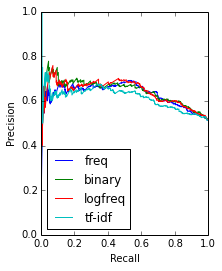

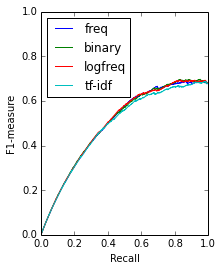

( freq ) AUC =  0.659168742217
( freq ) F1 =  0.63
( freq ) Accuracy =  0.63
( binary ) AUC =  0.666651841309
( binary ) F1 =  0.627318718381
( binary ) Accuracy =  0.631666666667
( logfreq ) AUC =  0.666996530866
( logfreq ) F1 =  0.634064080944
( logfreq ) Accuracy =  0.638333333333
( tf-idf ) AUC =  0.629836772816
( tf-idf ) F1 =  0.602040816327
( tf-idf ) Accuracy =  0.61


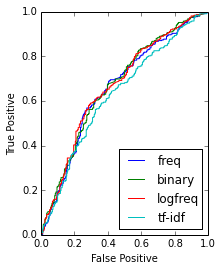

In [21]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

from sklearn.feature_extraction.text import TfidfVectorizer

def bin_f(x):
    return 1 if x > 0 else 0
n_vec_bin = numpy.vectorize(bin_f)
matrix_counts_bin = n_vec_bin(matrix_counts)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_bin, target)
binreg_bincounts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

def log_f(x):
    return math.log(x+1)
n_vec_log = numpy.vectorize(log_f)
matrix_counts_log = n_vec_log(matrix_counts)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_log, target)
logreg_logcounts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

tfidf_transformer = TfidfTransformer(norm=None)
matrix_tfidf = tfidf_transformer.fit_transform(temp_matrix).toarray()

X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
logreg_counts_l2_predicted_tfidf, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

plot.figure(figsize=(3,4))
rp_curve(Y_test, logreg_counts_l2_predicted, label='freq')
rp_curve(Y_test, binreg_bincounts_l2_predicted, label='binary')
rp_curve(Y_test, logreg_logcounts_l2_predicted, label='logfreq')
rp_curve(Y_test, logreg_counts_l2_predicted_tfidf, label='tf-idf')
plot.show()
plot.figure(figsize=(3,4))
f1_curve(Y_test, logreg_counts_l2_predicted, label='freq')
f1_curve(Y_test, binreg_bincounts_l2_predicted, label='binary')
f1_curve(Y_test, logreg_logcounts_l2_predicted, label='logfreq')
f1_curve(Y_test, logreg_counts_l2_predicted_tfidf, label='tf-idf')
plot.show()
plot.figure(figsize=(3,4))
roc_curve(Y_test, logreg_counts_l2_predicted, label='freq')
roc_curve(Y_test, binreg_bincounts_l2_predicted, label='binary')
roc_curve(Y_test, logreg_logcounts_l2_predicted, label='logfreq')
roc_curve(Y_test, logreg_counts_l2_predicted_tfidf, label='tf-idf')

# Стемминг и удаление стоп-слов

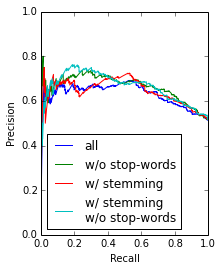

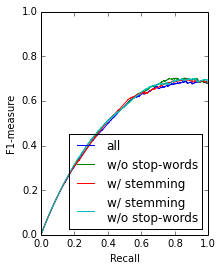

( all ) AUC =  0.659168742217
( all ) F1 =  0.63
( all ) Accuracy =  0.63
( w/o stop-words ) AUC =  0.692092154421
( w/o stop-words ) F1 =  0.647840531561
( w/o stop-words ) Accuracy =  0.646666666667
( w/ stemming ) AUC =  0.676447696139
( w/ stemming ) F1 =  0.638513513514
( w/ stemming ) Accuracy =  0.643333333333
( w/ stemming
w/o stop-words ) AUC =  0.690802348337
( w/ stemming
w/o stop-words ) F1 =  0.65776293823
( w/ stemming
w/o stop-words ) Accuracy =  0.658333333333


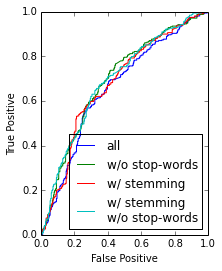

In [13]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
stemmer = PorterStemmer()
from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

stop_words = stopwords.words('russian')

count_vect_without_stopwords = CountVectorizer(stop_words=stop_words)
matrix_counts_without_stopwords = count_vect_without_stopwords.fit_transform(all_texts).toarray()

count_vect_with_lemm = CountVectorizer(tokenizer=tokenize)
matrix_counts_with_lemm = count_vect_with_lemm.fit_transform(all_texts).toarray()

count_vect_with_lemm_without_stopwords = CountVectorizer(stop_words=stop_words, tokenizer=tokenize)
matrix_counts_with_lemm_without_stopwords = count_vect_with_lemm_without_stopwords.fit_transform(all_texts).toarray()


X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_without_stopwords, target)
logreg_counts_l2_predicted_without_stopwords, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm, target)
logreg_counts_l2_predicted_with_lemm, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm_without_stopwords, target)
logreg_counts_l2_predicted_with_lemm_without_stopwords, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)

plot.figure(figsize=(3,4))
rp_curve(Y_test, logreg_counts_l2_predicted, label='all')
rp_curve(Y_test, logreg_counts_l2_predicted_without_stopwords, label='w/o stop-words')
rp_curve(Y_test, logreg_counts_l2_predicted_with_lemm, label='w/ stemming')
rp_curve(Y_test, logreg_counts_l2_predicted_with_lemm_without_stopwords, label='w/ stemming\nw/o stop-words')
plot.show()
plot.figure(figsize=(3,4))
f1_curve(Y_test, logreg_counts_l2_predicted, label='all')
f1_curve(Y_test, logreg_counts_l2_predicted_without_stopwords, label='w/o stop-words')
f1_curve(Y_test, logreg_counts_l2_predicted_with_lemm, label='w/ stemming')
f1_curve(Y_test, logreg_counts_l2_predicted_with_lemm_without_stopwords, label='w/ stemming\nw/o stop-words')
plot.show()
plot.figure(figsize=(3,4))
roc_curve(Y_test, logreg_counts_l2_predicted, label='all')
roc_curve(Y_test, logreg_counts_l2_predicted_without_stopwords, label='w/o stop-words')
roc_curve(Y_test, logreg_counts_l2_predicted_with_lemm, label='w/ stemming')
roc_curve(Y_test, logreg_counts_l2_predicted_with_lemm_without_stopwords, label='w/ stemming\nw/o stop-words')

# Выбор наиболее значимых признаков по результатам обучения логистической регрессии

## Для самых 5000 значимых

In [ ]:
pos_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][::-1][:5000]
neg_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][:5000]

print '\n', 'TOP 10 pos'
for idx in numpy.argsort(log_counts_model.coef_)[0][::-1][:10]: # последние 10 с максимальным коэфициентом
    print '{}, = {:.5f}'.format(words_as_features.get(idx), log_counts_model.coef_[0][idx])
print '\n', 'TOP 10 neg'
for idx in numpy.argsort(log_counts_model.coef_)[0][:10]: # последние 10 с минимальным коэфициентом
    print '{}, = {:.5f}'.format(words_as_features.get(idx), log_counts_model.coef_[0][idx])

select_matrix_counts = (matrix_counts.transpose()[list(set(pos_select_by_lr) | set(neg_select_by_lr))]).transpose()
X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

rp_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
rp_curve(Y_test, logreg_counts_l2_select_predicted, label='Logistic Regression (L2-regularization) select')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
f1_curve(Y_test, logreg_counts_l2_select_predicted, label='Logistic Regression (L2-regularization) select')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
roc_curve(Y_test, logreg_counts_l2_select_predicted, label='Logistic Regression (L2-regularization) select')

In [ ]:
# -*- coding: utf-8 -*-
pos_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][::-1][:30]
neg_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][:30]
print '\n', 'TOP 10 pos'
for idx in numpy.argsort(log_counts_model.coef_)[0][::-1][:30]: # последние 10 с максимальным коэфициентом
    print words_as_features.get(idx)  + " : " + str(log_counts_model.coef_[0][idx])
print '\n', 'TOP 10 neg'
for idx in numpy.argsort(log_counts_model.coef_)[0][:30]: # последние 10 с минимальным коэфициентом
    print words_as_features.get(idx)  + " : " + str(log_counts_model.coef_[0][idx])

# print pos_select_by_lr
# print neg_select_by_lr

# print pos_select_by_lr[7223]
# print pos_select_by_lr[39335 ]
# print pos_select_by_lr[28696 ]
# print pos_select_by_lr[11110 ]

## AUC в зависимости от количества самых значимых признаков

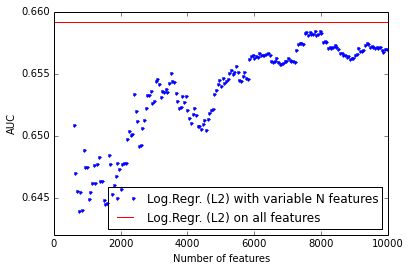

In [19]:
ga =  get_auc(Y_test, logreg_counts_l2_predicted), 
auc_map = {}
number_of_features_range = xrange(300, 5000, 25)#[2**(i/2.0) for i in xrange(2,34,1)]
for i in number_of_features_range:
    pos_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][::-1][:i]
    neg_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][:i]
    l_f = list(set(pos_select_by_lr) | set(neg_select_by_lr))
    n_f = len(l_f)
    select_matrix_counts = (matrix_counts.transpose()[l_f]).transpose()
    X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
    logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)
    auc_map[n_f] = get_auc(Y_test, logreg_counts_l2_select_predicted)

plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2) with variable N features')
plot.axhline(y=ga,xmin=0,xmax=20000,color='red', label='Log.Regr. (L2) on all features')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.legend(loc=0); #plot.xscale('log', basex=2);

In [20]:
print "Для всех признаков AUC = " + str(ga[0]) + "\n"
print "Максимальное AUC = " + str(max(auc_map.values()))
print "при количестве фич = " + str(auc_map.keys()[auc_map.values().index(max(auc_map.values()))])

Для всех признаков AUC = 0.659168742217

Максимальное AUC = 0.658446006049
при количестве фич = 7950


# Биграммы и триграммы

##Подсчет биграмм

In [22]:
count_vect_with2gramm = CountVectorizer(ngram_range=(1, 2))
matrix_counts_bigram = count_vect_with2gramm.fit_transform(all_texts).toarray()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_bigram, target)
logreg_counts_2gramm, log_counts_model_2gramm = logistic_reg(X_train, X_test, Y_train, C=0.25)

In [25]:
matrix_counts_bigram.shape

(2000, 94898)

##Подсчет триграмм

In [26]:
count_vect_with3gramm = CountVectorizer(ngram_range=(1, 3), max_features=800000)
matrix_counts_3gram = count_vect_with3gramm.fit_transform(all_texts).toarray()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_3gram, target)
logreg_counts_3gramm, log_counts_model_3gramm = logistic_reg(X_train, X_test, Y_train, C=0.25)

In [27]:
matrix_counts_3gram.shape

(2000, 174337)

## Сравнение с обычной лог рег при всех признаках

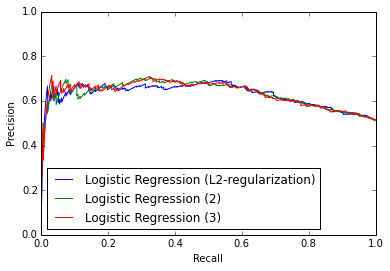

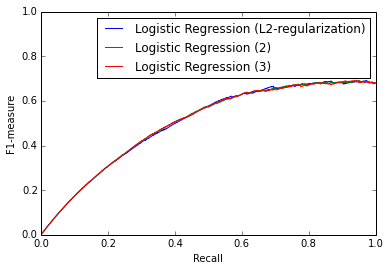

( Logistic Regression (L2-regularization) ) AUC =  0.659168742217
( Logistic Regression (L2-regularization) ) F1 =  0.63
( Logistic Regression (L2-regularization) ) Accuracy =  0.63
( Logistic Regression (2) ) AUC =  0.66210416296
( Logistic Regression (2) ) F1 =  0.635135135135
( Logistic Regression (2) ) Accuracy =  0.64
( Logistic Regression (3) ) AUC =  0.659669098025
( Logistic Regression (3) ) F1 =  0.636209813875
( Logistic Regression (3) ) Accuracy =  0.641666666667


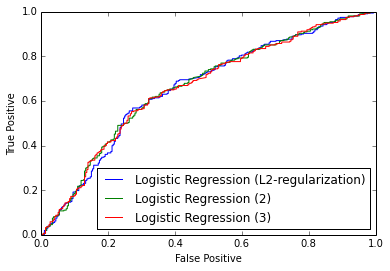

In [28]:
rp_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
rp_curve(Y_test, logreg_counts_2gramm, label='Logistic Regression (2)')
rp_curve(Y_test, logreg_counts_3gramm, label='Logistic Regression (3)')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
f1_curve(Y_test, logreg_counts_2gramm, label='Logistic Regression (2)')
f1_curve(Y_test, logreg_counts_3gramm, label='Logistic Regression (3)')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
roc_curve(Y_test, logreg_counts_2gramm, label='Logistic Regression (2)')
roc_curve(Y_test, logreg_counts_3gramm, label='Logistic Regression (3)')

## Уменьшение пристранства у биграмм

In [41]:
auc_map = {}
for i in [2**(i/4.0) for i in xrange(12,70,1)]:
    pos_select_by_lr = numpy.argsort(log_counts_model_2gramm.coef_)[0][::-1][:i]
    neg_select_by_lr = numpy.argsort(log_counts_model_2gramm.coef_)[0][:i]
    l_f = list(set(pos_select_by_lr) | set(neg_select_by_lr))
    n_f = len(l_f)
    select_matrix_counts = (matrix_counts_bigram.transpose()[l_f]).transpose()
    X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
    logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.25)
    auc_map[n_f] = get_auc(Y_test, logreg_counts_l2_select_predicted)

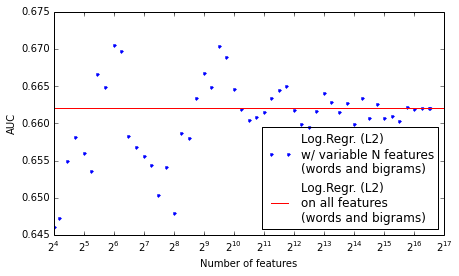

In [42]:
plot.figure(figsize=(7,4))
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2)\nw/ variable N features\n(words and bigrams)')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.axhline(y=0.66210416296,xmin=0,xmax=20000,color='red', label='Log.Regr. (L2)\non all features\n(words and bigrams)')
plot.legend(loc=0); plot.xscale('log', basex=2);

In [43]:
print "Bigrams max AUC = " + str(max(auc_map.values()))
print "Number of features = " + str(auc_map.keys()[auc_map.values().index(max(auc_map.values()))])

Bigrams max AUC = 0.670521259562
Number of features = 64


## Уменьшение пристранства у триграмм

In [47]:
auc_map = {}
for i in [2**(i/4.0) for i in xrange(12,72,1)]:
    pos_select_by_lr = numpy.argsort(log_counts_model_3gramm.coef_)[0][::-1][:i]
    neg_select_by_lr = numpy.argsort(log_counts_model_3gramm.coef_)[0][:i]
    l_f = list(set(pos_select_by_lr) | set(neg_select_by_lr))
    n_f = len(l_f)
    select_matrix_counts = (matrix_counts_3gram.transpose()[l_f]).transpose()
    X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
    logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)
    auc_map[n_f] = get_auc(Y_test, logreg_counts_l2_select_predicted)

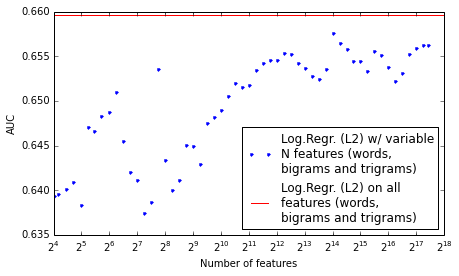

In [48]:
plot.figure(figsize=(7,4))
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2) w/ variable\nN features (words,\nbigrams and trigrams)')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.axhline(y=0.659669098025,xmin=0,xmax=20000,color='red', label='Log.Regr. (L2) on all\nfeatures (words,\nbigrams and trigrams)')
plot.legend(loc=0); plot.xscale('log', basex=2);

In [49]:
print "Trigrams max AUC = " + str(max(auc_map.values()))
print "Number of features = " + str(auc_map.keys()[auc_map.values().index(max(auc_map.values()))])

Trigrams max AUC = 0.657623198719
Number of features = 16384


# Другие методы ML

## Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier
c_range = range(1,1202,30) #range(1,21,1) - original
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=DecisionTreeClassifier(), 
    param_grid={
        'criterion': ['gini'],
        'max_depth': c_range
    }, 
    scoring='roc_auc', cv=4, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.61925
test score is 0.57500
best parameter set:
 * criterion=gini
 * max_depth=181


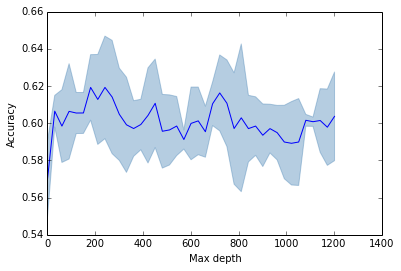

In [62]:
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c_range, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c_range, l1_mean, label='Avg. AUC for Decision Tree')
plot.xlabel('Max depth'); plot.ylabel('Accuracy'); 

## Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators_range = range(1, 1000, 100) + range(1000, 10000, 500) + range(10000, 50000, 2000)
n_estimators_range = range(1, 142, 20)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid={
        'n_estimators': n_estimators_range
    }, 
    scoring='accuracy', cv=3, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.62643
test score is 0.60833
best parameter set:
 * n_estimators=121


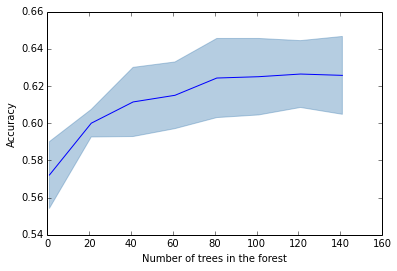

In [71]:
c = range(1, 142, 20)#[10,100,500,1000,2000]
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c, l1_mean, label='Avg. AUC for Random Forest')
plot.xlabel('Number of trees in the forest'); plot.ylabel('Accuracy'); 

## SVM

In [52]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
tree_grid_searcher = GridSearchCV(
    estimator=svm.SVC(), 
    param_grid={
        'C': [1,2,5,10,15,20,30,40,50,75,100,150,200]
    }, 
    scoring='roc_auc', cv=5, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.69096
test score is 0.63167
best parameter set:
 * C=15


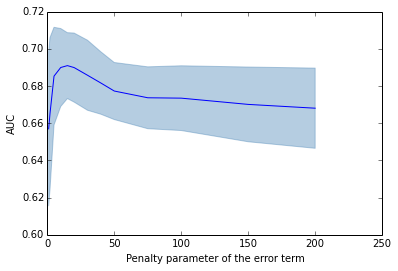

In [53]:
c_1 = [1,2,5,10,15,20,30,40,50,75,100,150,200]
l1_mean_1 = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std_1 = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c_1, l1_mean_1 - l1_std_1, l1_mean_1 + l1_std_1, color = 'steelblue', alpha = .4)
plot.plot(c_1, l1_mean_1, label='Avg. AUC for Random Forest')
plot.xlabel('Penalty parameter of the error term'); plot.ylabel('AUC');

In [54]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
tree_grid_searcher = GridSearchCV(
    estimator=svm.SVC(), 
    param_grid={
        'C': [1,2,5,10,15,20,30,40,50,75,100,150,200]
    }, 
    scoring='accuracy', cv=5, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.65786
test score is 0.64167
best parameter set:
 * C=10


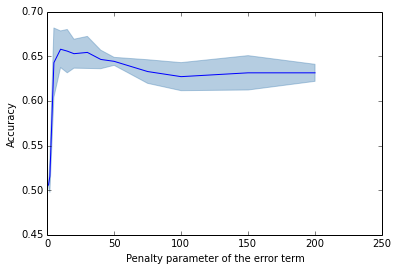

In [55]:
c_1 = [1,2,5,10,15,20,30,40,50,75,100,150,200]
l1_mean_1 = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std_1 = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c_1, l1_mean_1 - l1_std_1, l1_mean_1 + l1_std_1, color = 'steelblue', alpha = .4)
plot.plot(c_1, l1_mean_1, label='Avg. AUC for Random Forest')
plot.xlabel('Penalty parameter of the error term'); plot.ylabel('Accuracy');

## k-ближайших соседей

In [11]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={
        'n_neighbors': [5, 7, 21, 41, 81, 121, 161, 201, 251, 301]
    }, 
    scoring='roc_auc', cv=2, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.59016
test score is 0.56667
best parameter set:
 * n_neighbors=301


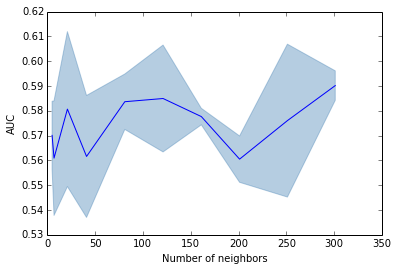

In [12]:
c_k3 = [5, 7, 21, 41, 81, 121, 161, 201, 251, 301]#range(1,11,1)+range(20,51,10)+[100, 200, 500]
l1_mean_k_3 = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std_k_3 = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c_k3, l1_mean_k_3 - l1_std_k_3, l1_mean_k_3 + l1_std_k_3, color = 'steelblue', alpha = .4)
plot.plot(c_k3, l1_mean_k_3, label='Avg. AUC for Random Forest')
plot.xlabel('Number of neighbors'); plot.ylabel('AUC')

# То, что не попало в статью

## Relevance Frequency

In [41]:
def get_after_rf_matrix(in_matrix, target, out_n_features, test_X):
    def bin_f(x):
        return 1 if x > 0 else 0
    n_vec = numpy.vectorize(bin_f)
    in_matrix_bin = n_vec(in_matrix)
    target = numpy.array(target)
    posit_pos = numpy.where(target == 1)[0]
    posit_neg = numpy.where(target == 0)[0]
    pos_rf_prepare = in_matrix_bin[posit_pos].sum(axis=0) 
    neg_rf_prepare = in_matrix_bin[posit_neg].sum(axis=0)
    pos_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(pos_rf_prepare, neg_rf_prepare)])
    neg_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(neg_rf_prepare, pos_rf_prepare)])
    l_pos = pos_rf.argsort()[-out_n_features//2:]
    l_neg = neg_rf.argsort()[-out_n_features//2:]
    return ((in_matrix.transpose()[list(set(l_pos) | set(l_neg))]).transpose(),
            (test_X.transpose()[list(set(l_pos) | set(l_neg))]).transpose())

### Сравнение RF и простой логистической регрессией 

#### Для 20000 фич

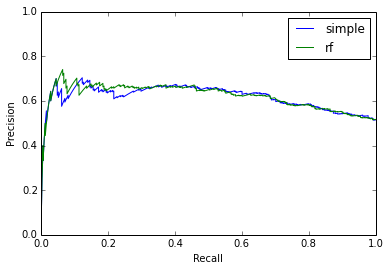

( simple ) AUC =  0.644380448319
( simple ) F1 =  0.616915422886
( simple ) Accuracy =  0.615
( rf ) AUC =  0.643257427504
( rf ) F1 =  0.598984771574
( rf ) Accuracy =  0.605


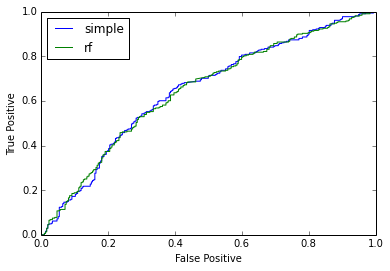

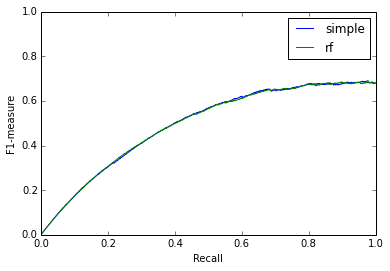

In [14]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
X_train_rf, X_test_rf = get_after_rf_matrix(X_train, Y_train, 20000, X_test)
logreg_rf20000_predicted, _ = logistic_reg(X_train_rf, X_test_rf, Y_train)

rp_curve(Y_test, logreg_counts_l2_predicted, label='simple')
rp_curve(Y_test, logreg_rf20000_predicted, label='rf')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='simple')
roc_curve(Y_test, logreg_rf20000_predicted, label='rf')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='simple')
f1_curve(Y_test, logreg_rf20000_predicted, label='rf')

#### Зависимость от количества оставляемых фич

In [45]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
auc_map = {}
f1_map = {}
for i in xrange(2000,19000,2000):
    print i
    X_train_rf, X_test_rf = get_after_rf_matrix(X_train, Y_train, i, X_test)
    logreg_rf_predicted, _ = logistic_reg(X_train_rf, X_test_rf, Y_train)
    auc_map[i] = get_auc(Y_test, logreg_rf_predicted)

2000
4000
6000
8000
10000
12000
14000
16000
18000


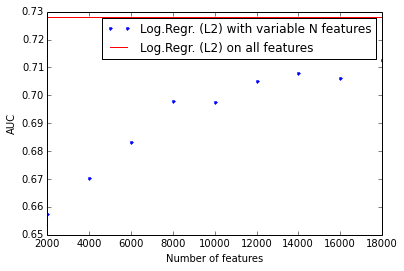

In [46]:
ga =  get_auc(Y_test, logreg_counts_l2_predicted), 
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2) with variable N features')
plot.axhline(y=ga,xmin=0,xmax=22000,color='red', label='Log.Regr. (L2) on all features')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.legend(loc=0); plot.xscale('linear');

In [44]:
matrix_counts.shape

(4000, 43485)

In [42]:
# X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
# model_svm = svm.SVC(C=1)
# model_svm.fit(X_train, Y_train)
# predicted = model_svm.predict_proba(X_test)


X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
auc_map = {}
f1_map = {}
for i in xrange(12000,24200,200):
    print i
    X_train_rf, X_test_rf = get_after_rf_matrix(X_train, Y_train, i, X_test)
    model_svm = svm.SVC(C=1, probability=True)
    model_svm.fit(X_train_rf, Y_train)
    predicted = model_svm.predict_proba(X_test_rf)
    auc_map[i] = get_auc(Y_test, predicted)

12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000


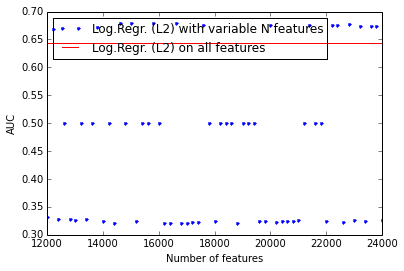

In [43]:
ga =  get_auc(Y_test, logreg_counts_l2_predicted), 
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2) with variable N features')
plot.axhline(y=ga,xmin=0,xmax=6000,color='red', label='Log.Regr. (L2) on all features')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.legend(loc=0); plot.xscale('linear');

## Сравнение лог рег и NBC

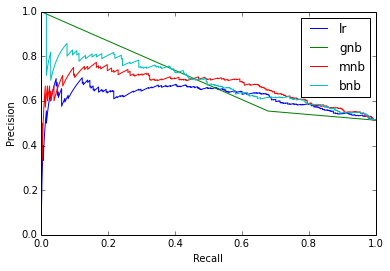

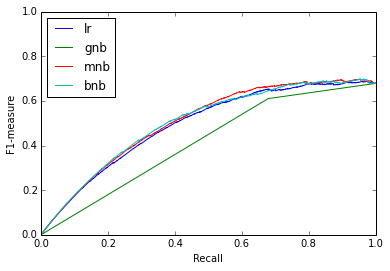

( lr ) AUC =  0.644380448319
( lr ) F1 =  0.616915422886
( lr ) Accuracy =  0.615
( gnb ) AUC =  0.551614481409
( gnb ) F1 =  0.610218978102
( gnb ) Accuracy =  0.555
( mnb ) AUC =  0.685281755915
( mnb ) F1 =  0.667687595712
( mnb ) Accuracy =  0.638333333333
( bnb ) AUC =  0.679032867817
( bnb ) F1 =  0.684754521964
( bnb ) Accuracy =  0.593333333333


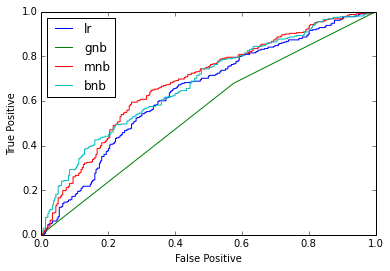

In [29]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
gnb.fit(X_train, Y_train)
gnb_predicted = gnb.predict_proba(X_test)
mnb.fit(X_train, Y_train)
mnb_predicted = mnb.predict_proba(X_test)
bnb.fit(X_train, Y_train)
bnb_predicted = bnb.predict_proba(X_test)

rp_curve(Y_test, logreg_counts_l2_predicted, label='lr')
rp_curve(Y_test, gnb_predicted, label='gnb')
rp_curve(Y_test, mnb_predicted, label='mnb')
rp_curve(Y_test, bnb_predicted, label='bnb')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='lr')
f1_curve(Y_test, gnb_predicted, label='gnb')
f1_curve(Y_test, mnb_predicted, label='mnb')
f1_curve(Y_test, bnb_predicted, label='bnb')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='lr')
roc_curve(Y_test, gnb_predicted, label='gnb')
roc_curve(Y_test, mnb_predicted, label='mnb')
roc_curve(Y_test, bnb_predicted, label='bnb')